# Cargamos datasets desde Kaggle a Google Colab

In [2]:
#Instalamos kaggle
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Nos conectamos a Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
#Creamos el directorio.kaggle en la ubicación temporal de google colab
!mkdir ~/.kaggle

In [5]:
#Subimos el archivo json a Google Drive y entonces copiamos a la ubicación temporal
! cp /content/drive/MyDrive/KaggleAPI/kaggle.json ~/.kaggle/kaggle.json

In [6]:
#Cambiamos los permisos de lectura y escritura
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
#Descargamos los datasets 
! kaggle datasets download thedevastator/jobs-dataset-from-glassdoor

  0% 0.00/3.23M [00:00<?, ?B/s]
100% 3.23M/3.23M [00:00<00:00, 162MB/s]


In [8]:
#Como Nel dataset está comprimido tenemos que descomprimir el archivo
! unzip jobs-dataset-from-glassdoor.zip

Archive:  jobs-dataset-from-glassdoor.zip
  inflating: eda_data.csv            
  inflating: glassdoor_jobs.csv      
  inflating: salary_data_cleaned.csv  


# Descargamos Spark y configuramos el entorno de trabajo

In [9]:
#Instalamos Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

#Descargamos Spark
!wget -q https://downloads.apache.org/spark/spark-3.2.3/spark-3.2.3-bin-hadoop3.2.tgz
#Dezipeamos el archivo descargado
!tar xf spark-3.2.3-bin-hadoop3.2.tgz
#verificamos la versión de spark que tenemos
!spark-submit --version

#Utilizamos la versión de spark para saber que versión de pyspark instalar
!pip install pyspark==3.2.3 #Cambiar a la versión de spark 
#Verificamos que la versión de pyspark sea la correcta
!pyspark --version

#Instalación de Spark en Python
!pip install -q findspark

#Configuración de variables de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop3.2"

#Importamos SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
#Verificación de la sesión de Spark
spark

/bin/bash: spark-submit: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.5/281.5 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.3-py2.py3-none-any.whl size=281990679 sha256=109db8c1faec71141e546189dad817d78d6df5ad19c37c562a57119d22a14a1c
  Stored in directory: /root/.cache/pip/wheels/cc/f4/8d/dfbbd536587311afde33711613a0c193f18e7d90b120801108
Successfully built pyspark
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.2.3
      /_/
                        
Using Scala version 2.12.15, OpenJDK 64-Bit Server VM, 11.0.18
Branch HEAD
Compiled by user sunchao on 2022-11-14T17:20:20Z
Revision b53c341e0fefbb33d115ab630369a18765b7763d
Url https://

# Librerías

In [180]:
#Importamos los objetos "StructType" y el "StructField"
#Estos objetos nos ayudarán a definir la metadata
from pyspark.sql.types import StructType, StructField

#Importamos los tipos de datos que usaremos
from pyspark.sql.types import IntegerType, StringType, DoubleType, DateType

#Importamos las librerías de funciones clasicas
import pyspark.sql.functions as f
from pyspark.sql.functions import udf, col

#Importamos la librería
import pandas as pd
import numpy as np

#Importamos la librería matplotlib.pyplot
import matplotlib.pyplot as plt

# Lectura y limpieza de datos

##Lectura y limpieza del archivo salary_data_cleaned.csv

In [11]:
dfSalaryData = spark.read.format("csv").option("MultiLine", True).option("header", True).load("/content/salary_data_cleaned.csv")

dfSalaryData.show()

dfSalaryData.count()

dfSalaryData.printSchema()

+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-----------------+----------+----------+----------+--------------------+---------+----------+----+---------+----+-----+----+-----+
|           Job Title|     Salary Estimate|     Job Description|              Rating|        Company Name|       Location|     Headquarters|                Size|             Founded|   Type of ownership|            Industry|              Sector|             Revenue|         Competitors|hourly|employer_provided|min_salary|max_salary|avg_salary|         company_txt|job_state|same_state| age|python_yn|R_yn|spark| aws|excel|
+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----------------+----------

In [12]:
dfSalaryData.columns

['Job Title',
 'Salary Estimate',
 'Job Description',
 'Rating',
 'Company Name',
 'Location',
 'Headquarters',
 'Size',
 'Founded',
 'Type of ownership',
 'Industry',
 'Sector',
 'Revenue',
 'Competitors',
 'hourly',
 'employer_provided',
 'min_salary',
 'max_salary',
 'avg_salary',
 'company_txt',
 'job_state',
 'same_state',
 'age',
 'python_yn',
 'R_yn',
 'spark',
 'aws',
 'excel']

In [13]:
dfSalaryData = spark.read.format("csv").option("MultiLine", True).option("header", True).schema(
    StructType(
        [
            StructField('Job Title', StringType(), True),
            StructField('Salary Estimate', StringType(), True),
            StructField('Job Description', StringType(), True),
            StructField('Rating', DoubleType(), True),
            StructField('Company Name', StringType(), True),
            StructField('Location', StringType(), True),
            StructField('Headquarters', StringType(), True),
            StructField('Size', StringType(), True),
            StructField('Founded', IntegerType(), True),
            StructField('Type of ownership', StringType(), True),
            StructField('Industry', StringType(), True),
            StructField('Sector', StringType(), True),
            StructField('Revenue', StringType(), True),
            StructField('Competitors', StringType(), True),
            StructField('hourly', StringType(), True),
            StructField('employer_provided', StringType(), True),
            StructField('min_salary', IntegerType(), True),
            StructField('max_salary', IntegerType(), True),
            StructField('avg_salary', DoubleType(), True),
            StructField('company_txt', StringType(), True),
            StructField('job_state', StringType(), True),
            StructField('same_state', StringType(), True),
            StructField('age', IntegerType(), True),
            StructField('python_yn', StringType(), True),
            StructField('R_yn', StringType(), True),
            StructField('spark', StringType(), True),
            StructField('aws', StringType(), True),
            StructField('excel', StringType(), True),
        ]
    )    
).load("/content/salary_data_cleaned.csv")

dfSalaryData.show()

dfSalaryData.printSchema()

+--------------------+--------------------+--------------------+------+--------------------+---------------+-----------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-----------------+----------+----------+----------+--------------------+---------+----------+----+---------+----+-----+----+-----+
|           Job Title|     Salary Estimate|     Job Description|Rating|        Company Name|       Location|     Headquarters|                Size|Founded|   Type of ownership|            Industry|              Sector|             Revenue|         Competitors|hourly|employer_provided|min_salary|max_salary|avg_salary|         company_txt|job_state|same_state| age|python_yn|R_yn|spark| aws|excel|
+--------------------+--------------------+--------------------+------+--------------------+---------------+-----------------+--------------------+-------+--------------------+--------------------+-------

In [14]:
df = pd.read_csv("/content/salary_data_cleaned.csv")

#df.head(130)

#df.info()

#df.describe()

In [15]:
dfSalaryDataLimpio = dfSalaryData.filter(
    (dfSalaryData['Job Title'].isNotNull()) &
    (dfSalaryData['Salary Estimate'].isNotNull()) &
    (dfSalaryData['Job Description'].isNotNull()) &
    (dfSalaryData['Rating'].isNotNull()) &
    (dfSalaryData['Rating'] > 0) &
    (dfSalaryData['Company Name'].isNotNull()) &
    (dfSalaryData['Location'].isNotNull()) &
    (dfSalaryData['Headquarters'].isNotNull()) &
    (dfSalaryData['Size'].isNotNull()) &
    (dfSalaryData['Founded'].isNotNull()) &
    (dfSalaryData['Founded'] > 0) &
    (dfSalaryData['Type of ownership'].isNotNull()) &
    (dfSalaryData['Industry'].isNotNull()) &
    (dfSalaryData['Sector'].isNotNull()) &
    (dfSalaryData['Revenue'].isNotNull()) &
    (dfSalaryData['Competitors'].isNotNull()) &
    (dfSalaryData['hourly'].isNotNull()) &
    (dfSalaryData['employer_provided'].isNotNull()) &
    (dfSalaryData['min_salary'].isNotNull()) &
    (dfSalaryData['max_salary'].isNotNull()) &
    (dfSalaryData['avg_salary'].isNotNull()) &
    (dfSalaryData['company_txt'].isNotNull()) &
    (dfSalaryData['job_state'].isNotNull()) &
    (dfSalaryData['same_state'].isNotNull()) &
    (dfSalaryData['age'].isNotNull()) &
    (dfSalaryData['age'] > 0) &
    (dfSalaryData['python_yn'].isNotNull()) &
    (dfSalaryData['R_yn'].isNotNull()) &
    (dfSalaryData['spark'].isNotNull()) &
    (dfSalaryData['aws'].isNotNull()) &
    (dfSalaryData['excel'].isNotNull())
)

dfSalaryDataLimpio.show()

dfSalaryDataLimpio.count()

+--------------------+--------------------+--------------------+------+--------------------+-----------------+-----------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-----------------+----------+----------+----------+--------------------+---------+----------+---+---------+----+-----+---+-----+
|           Job Title|     Salary Estimate|     Job Description|Rating|        Company Name|         Location|     Headquarters|                Size|Founded|   Type of ownership|            Industry|              Sector|             Revenue|         Competitors|hourly|employer_provided|min_salary|max_salary|avg_salary|         company_txt|job_state|same_state|age|python_yn|R_yn|spark|aws|excel|
+--------------------+--------------------+--------------------+------+--------------------+-----------------+-----------------+--------------------+-------+--------------------+--------------------+-----

628

In [16]:
#Veamos cuantos trabajos son de ciencia de datos

df1 = dfSalaryDataLimpio.groupBy(dfSalaryDataLimpio["Job Title"]).\
    agg(f.count(dfSalaryDataLimpio["Job Title"]).alias("Quantity of Jobs"))

df2 = df1.orderBy("Quantity of Jobs", ascending=False)

df2.show(truncate=False)
#Recordemos que existen ramas de la ciencia de datos, como: Data Engineer, 
#Data Analyst, Machine Learning, etc.
#Asi que, como podemos ver, todos los trabajos son de Data Science

+----------------------------------------------+----------------+
|Job Title                                     |Quantity of Jobs|
+----------------------------------------------+----------------+
|Data Scientist                                |106             |
|Data Engineer                                 |39              |
|Senior Data Scientist                         |32              |
|Data Analyst                                  |14              |
|Senior Data Engineer                          |12              |
|Senior Data Analyst                           |10              |
|Sr. Data Engineer                             |6               |
|Marketing Data Analyst                        |6               |
|Lead Data Scientist                           |6               |
|Principal Data Scientist                      |5               |
|Machine Learning Engineer                     |5               |
|Food Scientist - Developer                    |4               |
|Analytics

In [42]:
#Extraemos de dfSalaryDataLimpio la columna avg_salary
avg_salaries_data = dfSalaryDataLimpio.select(
    dfSalaryDataLimpio["avg_salary"],    
)

avg_salaries_data.show(4)

+----------+
|avg_salary|
+----------+
|      72.0|
|      87.5|
|      85.0|
|      76.5|
+----------+
only showing top 4 rows



In [22]:
#Extraemos los 100 salarios más altos con repeticiones
top_100_high_salary = avg_salaries_data.orderBy(avg_salaries_data["avg_salary"], ascending = False).limit(100)

top_100_high_salary.show()

top_100_high_salary.count()

+----------+
|avg_salary|
+----------+
|     254.0|
|     254.0|
|     254.0|
|     237.5|
|     232.5|
|     221.5|
|     205.0|
|     205.0|
|     205.0|
|     194.5|
|     194.5|
|     194.0|
|     194.0|
|     184.5|
|     184.5|
|     181.0|
|     181.0|
|     181.0|
|     180.0|
|     180.0|
+----------+
only showing top 20 rows



100

In [47]:
#Convertimos top_100_high_salary en una lista
list_high_salaries = top_100_high_salary.rdd.map(lambda x: x[0]).collect()

#Lista de los distintos salarios que se encuentra en el top 100
highest_salaries = list(set(list_high_salaries))

len(highest_salaries)

43

In [40]:
#filtramos aquellos registros cuyo avg_salary esté en la lista highest_salaries 

high_salary_data = dfSalaryDataLimpio.filter(
    dfSalaryDataLimpio["avg_salary"].isin(highest_salaries)
).orderBy("avg_salary", ascending=False).limit(100) #Obtenemos los 100 primeros registros

high_salary_data.show()

high_salary_data.count()


+--------------------+--------------------+--------------------+------+--------------------+-----------------+-----------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-----------------+----------+----------+----------+--------------------+---------+----------+---+---------+----+-----+---+-----+
|           Job Title|     Salary Estimate|     Job Description|Rating|        Company Name|         Location|     Headquarters|                Size|Founded|   Type of ownership|            Industry|              Sector|             Revenue|         Competitors|hourly|employer_provided|min_salary|max_salary|avg_salary|         company_txt|job_state|same_state|age|python_yn|R_yn|spark|aws|excel|
+--------------------+--------------------+--------------------+------+--------------------+-----------------+-----------------+--------------------+-------+--------------------+--------------------+-----

100

In [45]:
#Extraemos los 100 salarios más bajos con repeticiones
top_100_low_salary = avg_salaries_data.orderBy(avg_salaries_data["avg_salary"], ascending = True).limit(100)

top_100_low_salary.show()

top_100_low_salary.count()

+----------+
|avg_salary|
+----------+
|      13.5|
|      13.5|
|      15.5|
|      20.0|
|      20.5|
|      20.5|
|      21.5|
|      21.5|
|      21.5|
|      21.5|
|      25.0|
|      25.0|
|      26.5|
|      26.5|
|      26.5|
|      27.5|
|      27.5|
|      27.5|
|      27.5|
|      27.5|
+----------+
only showing top 20 rows



100

In [49]:
#Convertimos top_100_low_salary en una lista
list_low_salaries = top_100_low_salary.rdd.map(lambda x: x[0]).collect()

#Lista de los 100 distintos salarios que son más bajos
low_salaries = list(set(list_low_salaries))

len(low_salaries)

41

In [50]:
#filtramos aquellos registros cuyo avg_salary esté en la lista low_salaries 

low_salary_data = dfSalaryDataLimpio.filter(
    dfSalaryDataLimpio["avg_salary"].isin(low_salaries)
).orderBy("avg_salary", ascending=False).limit(100) #Obtenemos los 100 primeros registros

low_salary_data.show()

low_salary_data.count()

+--------------------+--------------------+--------------------+------+--------------------+-----------------+-----------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-----------------+----------+----------+----------+--------------------+---------+----------+---+---------+----+-----+---+-----+
|           Job Title|     Salary Estimate|     Job Description|Rating|        Company Name|         Location|     Headquarters|                Size|Founded|   Type of ownership|            Industry|              Sector|             Revenue|         Competitors|hourly|employer_provided|min_salary|max_salary|avg_salary|         company_txt|job_state|same_state|age|python_yn|R_yn|spark|aws|excel|
+--------------------+--------------------+--------------------+------+--------------------+-----------------+-----------------+--------------------+-------+--------------------+--------------------+-----

100

In [69]:
#Establecemos el grado del salario ganado por los profesionales com mayores sueldos como "high"
dfHigh = high_salary_data.select("*", f.lit("high").alias("salary_grade"))

dfHigh.show(2)

+--------------------+--------------------+--------------------+------+--------------------+-----------+------------+----------------+-------+-----------------+------------------+---------+------------------+--------------------+------+-----------------+----------+----------+----------+--------------------+---------+----------+---+---------+----+-----+---+-----+------------+
|           Job Title|     Salary Estimate|     Job Description|Rating|        Company Name|   Location|Headquarters|            Size|Founded|Type of ownership|          Industry|   Sector|           Revenue|         Competitors|hourly|employer_provided|min_salary|max_salary|avg_salary|         company_txt|job_state|same_state|age|python_yn|R_yn|spark|aws|excel|salary_grade|
+--------------------+--------------------+--------------------+------+--------------------+-----------+------------+----------------+-------+-----------------+------------------+---------+------------------+--------------------+------+--------

In [70]:
#Establecemos el grado del salario ganado por los profesionales com menores sueldos como "Low"
dfLow = low_salary_data.select("*", f.lit("low").alias("salary_grade"))

dfLow.show(2)

+--------------------+--------------------+--------------------+------+--------------+------------+----------------+----------------+-------+-----------------+--------------------+--------------------+------------------+--------------------+------+-----------------+----------+----------+----------+-----------+---------+----------+---+---------+----+-----+---+-----+------------+
|           Job Title|     Salary Estimate|     Job Description|Rating|  Company Name|    Location|    Headquarters|            Size|Founded|Type of ownership|            Industry|              Sector|           Revenue|         Competitors|hourly|employer_provided|min_salary|max_salary|avg_salary|company_txt|job_state|same_state|age|python_yn|R_yn|spark|aws|excel|salary_grade|
+--------------------+--------------------+--------------------+------+--------------+------------+----------------+----------------+-------+-----------------+--------------------+--------------------+------------------+------------------

In [72]:
#Unimos los dataframes
df = dfHigh.union(dfLow)

df.show()

df.count()

+--------------------+--------------------+--------------------+------+--------------------+-----------------+-----------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+------+-----------------+----------+----------+----------+--------------------+---------+----------+---+---------+----+-----+---+-----+------------+
|           Job Title|     Salary Estimate|     Job Description|Rating|        Company Name|         Location|     Headquarters|                Size|Founded|   Type of ownership|            Industry|              Sector|             Revenue|         Competitors|hourly|employer_provided|min_salary|max_salary|avg_salary|         company_txt|job_state|same_state|age|python_yn|R_yn|spark|aws|excel|salary_grade|
+--------------------+--------------------+--------------------+------+--------------------+-----------------+-----------------+--------------------+-------+--------------------+

200

# 1. Identifique que factores afectan más los salarios de la ciencia de datos

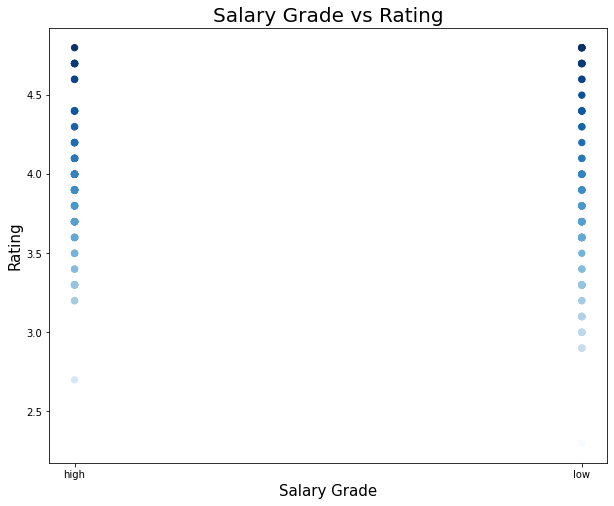

In [121]:
x1 = df.toPandas()["Rating"].values
x2 = df.toPandas()["salary_grade"].values

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(x2, x1, c=x1, marker='o', cmap=plt.cm.Blues, edgecolors=None, s=40)

plt.title("Salary Grade vs Rating", fontsize=20)
plt.xlabel("Salary Grade", fontsize=15)
plt.ylabel("Rating", fontsize=15)

plt.show()

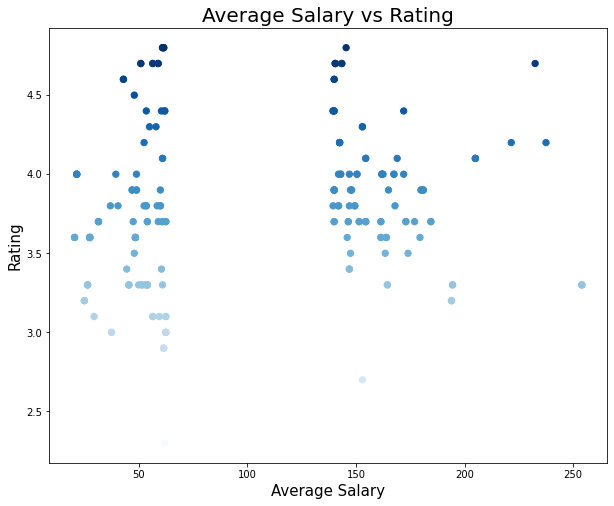

In [128]:
x1 = df.toPandas()["Rating"].values
x2 = df.toPandas()["avg_salary"].values

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(x2, x1, c=x1, marker='o', cmap=plt.cm.Blues, edgecolors=None, s=40)

plt.title("Average Salary vs Rating", fontsize=20)
plt.xlabel("Average Salary", fontsize=15)
plt.ylabel("Rating", fontsize=15)

plt.show()

#De aqui podemos observar que un rating muy bajo, digamos menor que 3.1 asegura
#que el salario será muy bajo con una sola excepción.
#Para ratings mayores a 3.1 es posible encontrar trabajos con salarios bajos y altos

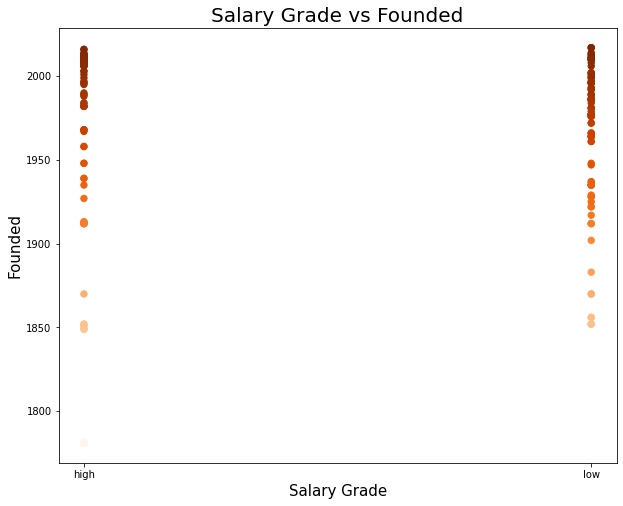

In [131]:
x1 = df.toPandas()["salary_grade"].values
x2 = df.toPandas()["Founded"].values

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(x1, x2, c=x2, marker='o', cmap=plt.cm.Oranges, edgecolors=None, s=40)

plt.title("Salary Grade vs Founded", fontsize=20)
plt.xlabel("Salary Grade", fontsize=15)
plt.ylabel("Founded", fontsize=15)

plt.show()

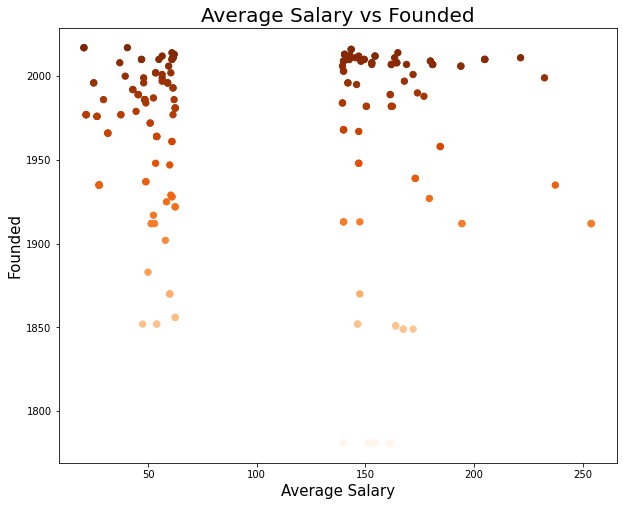

In [159]:
x1 = df.toPandas()["avg_salary"].values
x2 = df.toPandas()["Founded"].values

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(x1, x2, c=x2, marker='o', cmap=plt.cm.Oranges, edgecolors=None, s=40)

plt.title("Average Salary vs Founded", fontsize=20)
plt.xlabel("Average Salary", fontsize=15)
plt.ylabel("Founded", fontsize=15)

plt.show()
#La fecha de fundación de la empresa influye en el salario a ganar
#Mientras más antigua sea la empresa, los salarios no serán tan altos como
#en empresas más contemporáneas. Además,los salarios no serán tan bajos como
#en empresas más contemporáneas

In [243]:
df3 = dfHigh.groupBy(df["Job Title"]).\
    agg(f.count(dfHigh["Job Title"]).alias("Quantity of Jobs"))

df3 = df3.sort("Quantity of Jobs", ascending=False)

df3.show()

+--------------------+----------------+
|           Job Title|Quantity of Jobs|
+--------------------+----------------+
|Senior Data Scien...|              14|
|      Data Scientist|              13|
| Lead Data Scientist|               6|
|Principal Data Sc...|               5|
|Director II, Data...|               3|
| Staff Data Engineer|               3|
|Senior Insurance ...|               3|
|  Lead Data Engineer|               3|
|Staff Machine Lea...|               3|
|Associate Directo...|               3|
|Principal Data Sc...|               3|
|Director II, Data...|               2|
|Sr. Scientist, Qu...|               2|
|Senior Manager, E...|               2|
|Director Data Sci...|               2|
|PL Actuarial-Lead...|               2|
|Lead Big Data Eng...|               2|
|Sr. Scientist - D...|               2|
|Data Scientist - ...|               2|
|Data Science Engi...|               2|
+--------------------+----------------+
only showing top 20 rows



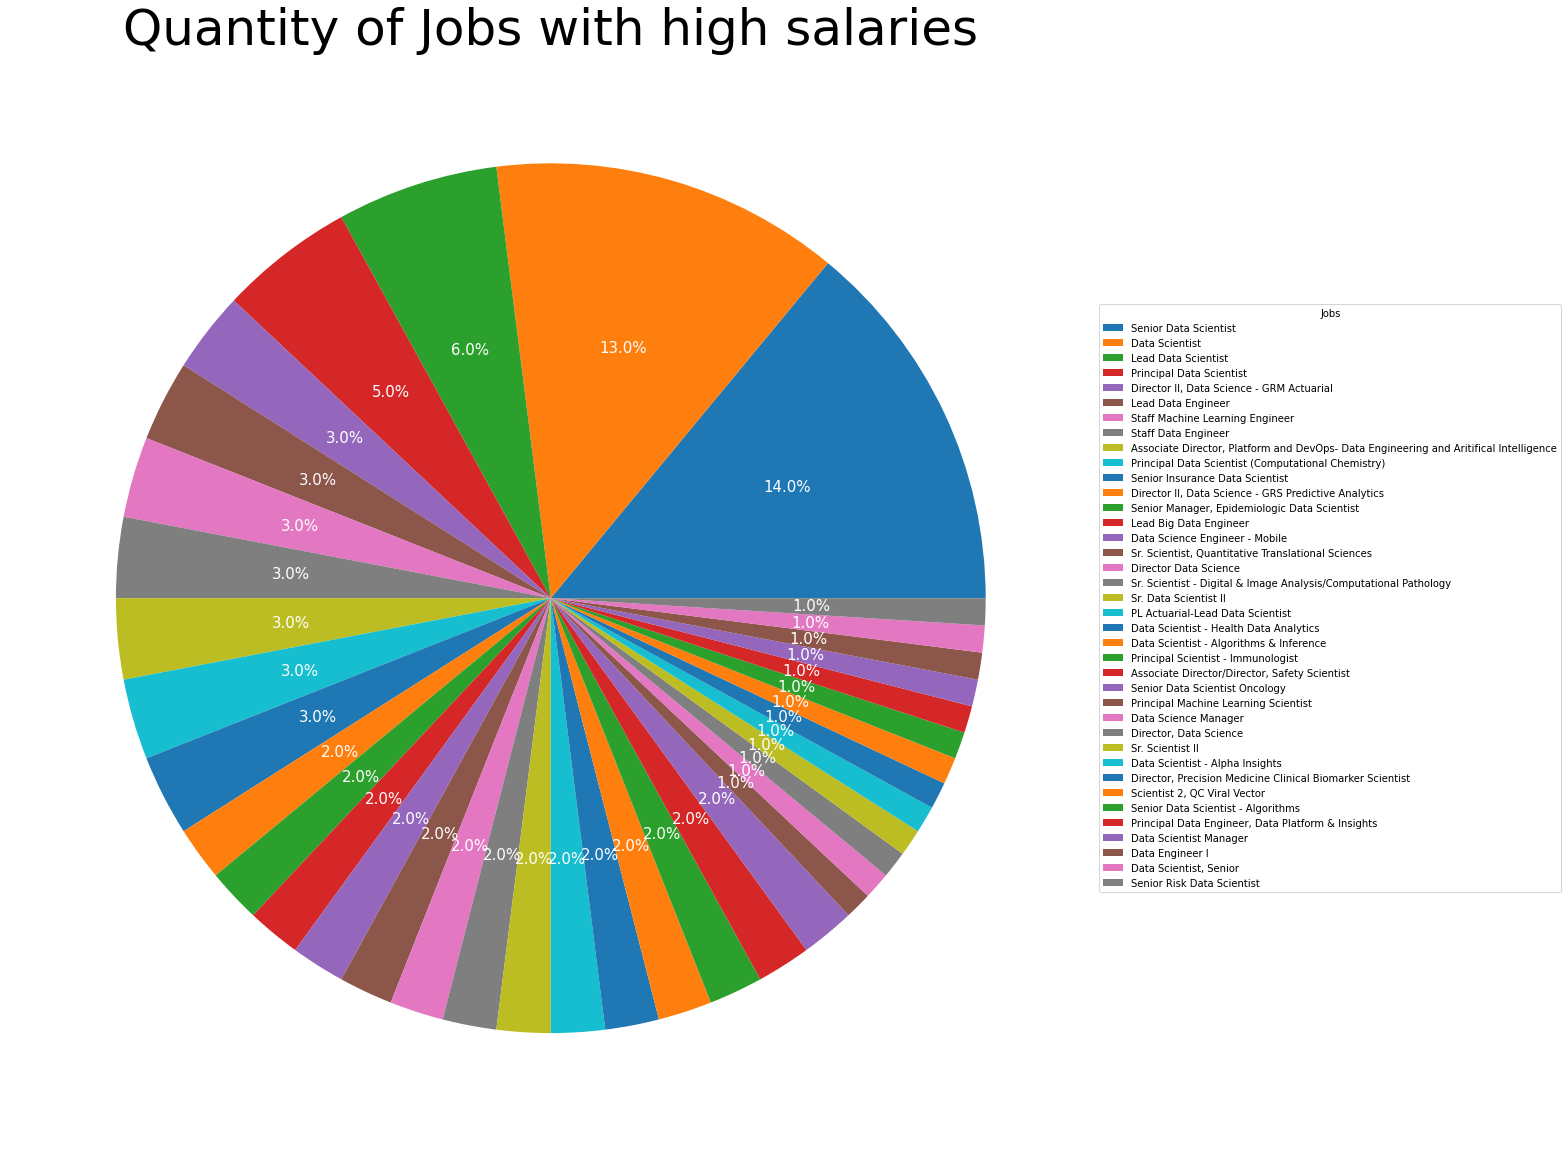

In [259]:
values = df3.rdd.map(lambda x: x[1]).collect()
legends = df3.rdd.map(lambda x: x[0]).collect()

fig, ax = plt.subplots(figsize=(30, 20), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%"


wedges, texts, autotexts = ax.pie(values, autopct=lambda x: func(x, values),textprops=dict(color="w"))

ax.legend(wedges, legends,
          title="Jobs",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=15)

ax.set_title("Quantity of Jobs with high salaries", fontsize=50)

plt.show()